# Yankees - Propensity Event- InsertData
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 02, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [17]:
#import psycopg2
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV #cross validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import datetime
import pyodbc
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import getpass

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [18]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = 'Y34@PSc^n@JAG=4%p8194'#getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [19]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrYankees].[ds].[getPropensityEventScoring] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

(1065064, 46)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065064 entries, 0 to 1065063
Data columns (total 46 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   lkupClientId            1065064 non-null  int64  
 1   dimCustomerMasterId     1065064 non-null  int64  
 2   dimEventId              1065064 non-null  int64  
 3   inMarket                1065064 non-null  int64  
 4   customerNumber          1065064 non-null  object 
 5   year                    1065064 non-null  int64  
 6   productGrouping         1065064 non-null  object 
 7   Tier                    1065064 non-null  int64  
 8   eventDay                1065064 non-null  int64  
 9   totalSpent              1065064 non-null  float64
 10  recentDate              1065064 non-null  object 
 11  attendancePercent       1065064 non-null  float64
 12  renewedBeforeDays       1065064 non-null  int64  
 13  isBuyer                 1065064 non-null  object 
 14  so

In [22]:
dfyear = df[df["year"] <= 2019]
dfyear.head()

,lkupClientId,dimCustomerMasterId,dimEventId,inMarket,customerNumber,year,productGrouping,Tier,eventDay,totalSpent,...,internal_note,left_message,outbound_email,outbound_phonecall,phonecall,text,unknown,credits_after_refund,NumberofGamesPerSeason,isNextGameBuyer
0,53,23,414,0,4131869,2017,Online Individual Game,4,5,92.0,...,0,0,0,0,0,0,0,0.0,79,0
1,53,169,414,1,22170392,2017,Online Individual Game,4,5,600.0,...,0,0,0,0,0,0,0,0.0,79,0
2,53,169,586,1,22170392,2017,Online Individual Game,3,6,550.0,...,0,0,0,0,0,0,0,0.0,79,0
3,53,169,656,1,22170392,2017,Online Individual Game,2,6,1040.0,...,0,0,0,0,0,0,0,0.0,79,0
4,53,218,618,0,15919851,2017,Online Individual Game,2,6,260.0,...,0,0,0,0,0,0,0,0.0,79,0


In [23]:
dfyear['year'].unique()

array([2017, 2018, 2019])

In [24]:
df3 = dfyear[["dimCustomerMasterId",
        "inMarket",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "eventDay",
        "Tier"]]
df3.head()

,dimCustomerMasterId,inMarket,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,totalGames,recency,click_link,fill_out_form,open_email,send_email,unsubscribe_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,eventDay,Tier
0,23,0,1.0,0,1825,0,42.69,2,0,0,0,102,825,0,0.123636,0.000000,0.000000,5,4
1,169,1,1.0,53,3650,53,21.11,5,0,0,0,0,0,0,0.000000,0.000000,0.000000,5,4
2,169,1,1.0,5,3650,54,21.11,5,0,0,0,0,0,0,0.000000,0.000000,0.000000,6,3
3,169,1,1.0,1,3650,96,21.11,5,0,0,0,0,0,0,0.000000,0.000000,0.000000,6,2
4,218,0,1.0,122,4380,122,46.45,2,0,36,0,84,888,0,0.094595,0.040541,0.428571,6,2


In [25]:
df3['dimCustomerMasterId']= pd.to_numeric(df3['dimCustomerMasterId'])
df3['attendancePercent']= pd.to_numeric(df3['attendancePercent'])
df3['distToVenue']= pd.to_numeric(df3['distToVenue'])
df3['clickToOpenRatio']= pd.to_numeric(df3['clickToOpenRatio'])
df3['clickToSendRatio']= pd.to_numeric(df3['clickToSendRatio'])
df3['openToSendRatio']= pd.to_numeric(df3['openToSendRatio'])

In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888829 entries, 0 to 888828
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dimCustomerMasterId  888829 non-null  int64  
 1   inMarket             888829 non-null  int64  
 2   attendancePercent    888829 non-null  float64
 3   renewedBeforeDays    888829 non-null  int64  
 4   source_tenure        888829 non-null  int64  
 5   tenure               888829 non-null  int64  
 6   distToVenue          888829 non-null  float64
 7   totalGames           888829 non-null  int64  
 8   recency              888829 non-null  int64  
 9   click_link           888829 non-null  int64  
 10  fill_out_form        888829 non-null  int64  
 11  open_email           888829 non-null  int64  
 12  send_email           888829 non-null  int64  
 13  unsubscribe_email    888829 non-null  int64  
 14  openToSendRatio      888829 non-null  float64
 15  clickToSendRatio 

In [26]:
X = df3.drop(['Tier'], axis=1).copy()
y = df3['Tier'].copy()

In [27]:
clf= xgb.XGBClassifier(objective='binary:logistic',seed=42,gamma=0.25,lear_rate=0.1,max_depth=6,reg_lambda=20,scale_pos_weight=3,subsample=0.9,colsample_bytree=0.5)
clf.fit(X,y,verbose=True,early_stopping_rounds=10,eval_metric='aucpr',eval_set=[(X,y)])

[12:02:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "lear_rate", "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBoostError: [12:02:49] /Users/travis/build/dmlc/xgboost/src/metric/rank_metric.cc:507: Check failed: preds.Size() == info.labels_.Size() (4444145 vs. 888829) : label size predict size not match
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013efa8de4 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x000000013f08e2b9 xgboost::metric::EvalAucPR::Eval(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, bool) + 537
  [bt] (2) 3   libxgboost.dylib                    0x000000013f05b983 xgboost::LearnerImpl::EvalOneIter(int, std::__1::vector<std::__1::shared_ptr<xgboost::DMatrix>, std::__1::allocator<std::__1::shared_ptr<xgboost::DMatrix> > > const&, std::__1::vector<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::allocator<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > const&) + 2355
  [bt] (3) 4   libxgboost.dylib                    0x000000013efa022c XGBoosterEvalOneIter + 572
  [bt] (4) 5   libffi.dylib                        0x00007fff2dbb08f5 ffi_call_unix64 + 85
  [bt] (5) 6   ???                                 0x00007ffee78198e0 0x0 + 140732782450912



### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
        "inMarket",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "Tier",
        "eventDay",
        "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
#df_dataset = df_dataset[df_dataset["Tier"] == {1,2,3} ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (755505, 20)
Unseen Data For Predictions: (133324, 20)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="Tier", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=["inMarket",
        "attendancePercent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "eventDay",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["gbc", "lightgbm", "lr", "rf", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6653,0.8914,0.6031,0.6627,0.6609,0.5506,0.5513,42.6790
xgboost,Extreme Gradient Boosting,0.6595,0.8950,0.5916,0.6634,0.6534,0.5418,0.5431,92.3950
lightgbm,Light Gradient Boosting Machine,0.6522,0.8897,0.5862,0.6573,0.6458,0.5322,0.5337,7.1940
gbc,Gradient Boosting Classifier,0.5817,0.8458,0.5088,0.5942,0.5686,0.4380,0.4407,146.1020
lr,Logistic Regression,0.4420,0.7057,0.3116,0.4074,0.3900,0.2174,0.2312,51.8650


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6656,0.8924,0.6028,0.6633,0.6613,0.5508,0.5515
1,0.6624,0.8908,0.6022,0.6598,0.6582,0.5469,0.5476
2,0.6660,0.8918,0.6047,0.6636,0.6619,0.5518,0.5524
3,0.6656,0.8912,0.6034,0.6626,0.6614,0.5510,0.5517
4,0.6693,0.8918,0.6075,0.6667,0.6651,0.5561,0.5568
5,0.6641,0.8920,0.5997,0.6616,0.6597,0.5489,0.5496
6,0.6650,0.8916,0.6036,0.6621,0.6607,0.5503,0.5509
7,0.6625,0.8904,0.5992,0.6599,0.6578,0.5467,0.5475
8,0.6664,0.8913,0.6037,0.6638,0.6618,0.5519,0.5526
9,0.6657,0.8907,0.6040,0.6633,0.6613,0.5511,0.5518


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(176235, 46)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,dimEventId,inMarket,customerNumber,year,productGrouping,Tier,eventDay,totalSpent,...,unknown,credits_after_refund,NumberofGamesPerSeason,isNextGameBuyer,Label,Score_1,Score_2,Score_3,Score_4,Score_5
888829,53,162,866,False,10605279,2021,Online Individual Game,6,7,88.0,...,0,0.0,94,0,2,0.18,0.37,0.11,0.34,0.00
888830,53,174,904,True,11896281,2021,Online Individual Game,6,2,65.0,...,0,0.0,94,0,2,0.02,0.80,0.00,0.16,0.02
888831,53,439,913,True,1213275,2021,Online Individual Game,3,7,170.0,...,0,0.0,94,0,2,0.31,0.37,0.14,0.18,0.00
888832,53,439,1260,True,1213275,2021,Online Individual Game,6,3,0.0,...,0,0.0,94,0,5,0.01,0.05,0.03,0.37,0.54
888833,53,822,905,True,10605691,2021,Online Individual Game,4,7,660.0,...,0,0.0,94,0,2,0.15,0.31,0.27,0.27,0.00


In [11]:
new_predictions["Label"].value_counts()

4    49846
3    44130
2    39673
1    32804
5     9782
Name: Label, dtype: int64

In [20]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    118629
(0.2, 0.4]        34617
(0.6, 0.8]        10306
(0.4, 0.6]         7652
(0.8, 1.0]         5031
Name: Score_1, dtype: int64

In [12]:
new_predictions["Score_2"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    75824
(0.2, 0.4]       62596
(0.4, 0.6]       22775
(0.6, 0.8]       12413
(0.8, 1.0]        2627
Name: Score_2, dtype: int64

In [13]:
new_predictions["Score_3"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    97783
(0.2, 0.4]       41087
(0.4, 0.6]       25100
(0.6, 0.8]       11168
(0.8, 1.0]        1097
Name: Score_3, dtype: int64

In [14]:
new_predictions["Score_4"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    102005
(0.2, 0.4]        28625
(0.4, 0.6]        21485
(0.6, 0.8]        17240
(0.8, 1.0]         6880
Name: Score_4, dtype: int64

In [21]:
new_predictions["Score_5"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    152945
(0.2, 0.4]        14071
(0.4, 0.6]         7230
(0.6, 0.8]         1632
(0.8, 1.0]          357
Name: Score_5, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

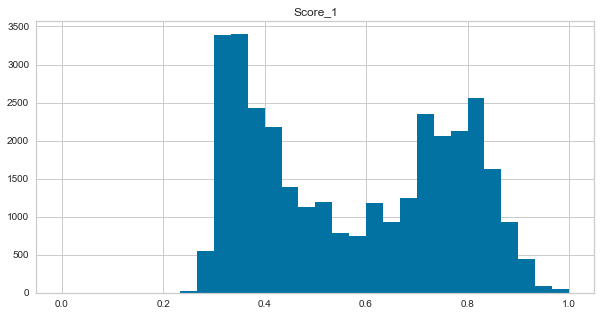

In [22]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_2'}>]], dtype=object)

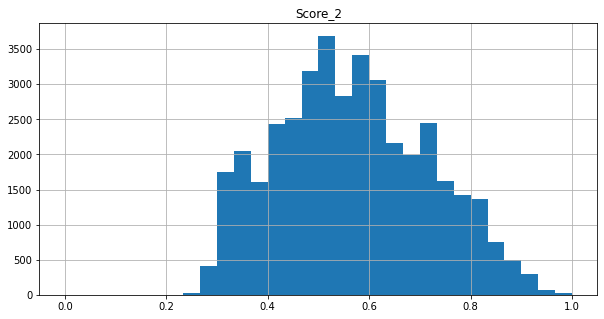

In [15]:
new_predictions[new_predictions["Label"]==2][["Score_2"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_3'}>]], dtype=object)

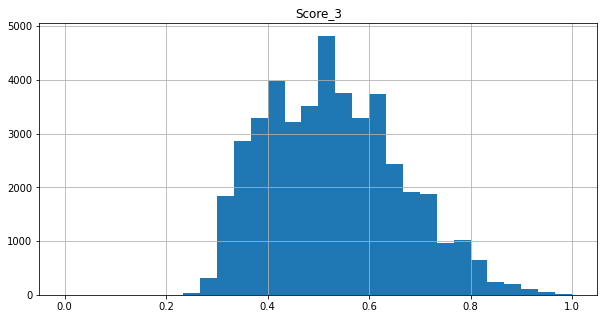

In [16]:
new_predictions[new_predictions["Label"]==3][["Score_3"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_4'}>]], dtype=object)

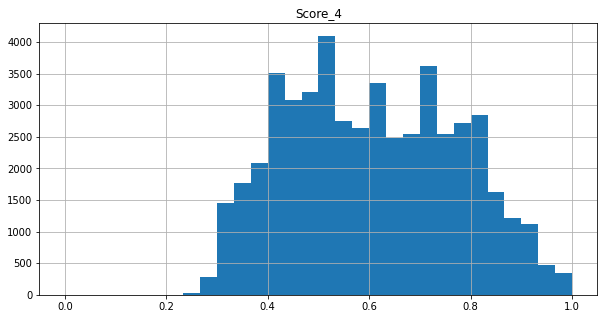

In [17]:
new_predictions[new_predictions["Label"]==4][["Score_4"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_5'}>]], dtype=object)

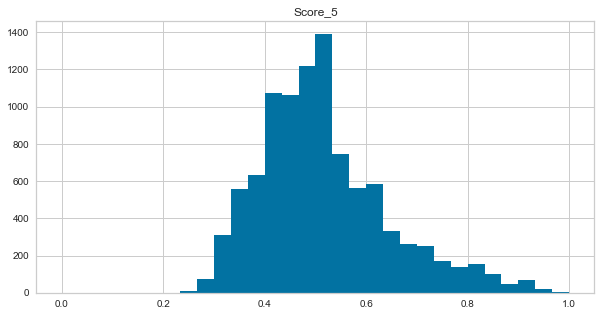

In [23]:
new_predictions[new_predictions["Label"]==5][["Score_5"]].hist(bins=30, figsize=(10,5), range=[0,1])

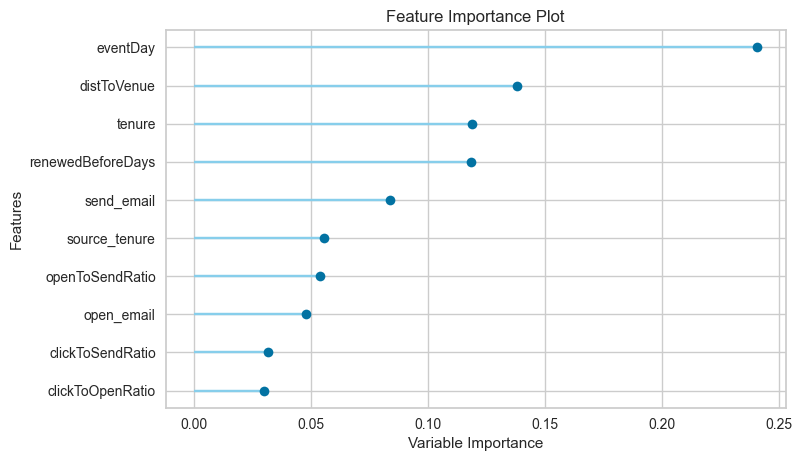

In [18]:
plot_model(best_model, plot='feature')

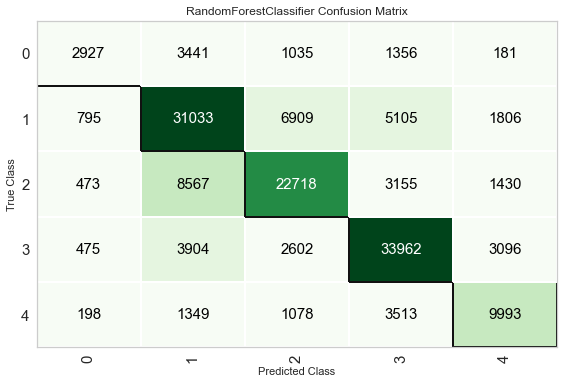

In [19]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.